In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

import os

DRIVE_PROJECT_PATH = "/content/drive/MyDrive/My_Project/"


ZIP_FILE_PATH = os.path.join(DRIVE_PROJECT_PATH, "wisdm_data.zip")

print(f"Unzipping {ZIP_FILE_PATH}...")
!unzip -q "{ZIP_FILE_PATH}" -d "/content/temp_data/"

DATA_GLOB_PATTERN = "/content/temp_data/data_*.csv"
print("Done. All files are unzipped and ready for Part 1.")

Unzipping /content/drive/MyDrive/My_Project/wisdm_data.zip...
replace /content/temp_data/WISDM-51/WISDM-dataset-description.pdf? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace /content/temp_data/WISDM-51/data_1600_accel_phone.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
Done. All files are unzipped and ready for Part 1.


In [ ]:

import pandas as pd
import numpy as np
import glob
import os

print('--- Starting Part 1 & 2: Merge and Extract Features ---')

file_list = glob.glob("/content/temp_data/WISDM-51/data_*.csv")

if not file_list:
    print(f"No data files found at {DATA_GLOB_PATTERN}. Check Cell 2 and your zip file.")
else:
    print(f"Found {len(file_list)} files to process...")
    features = []

    
    WINDOW_SIZE = 60
    STEP_SIZE = 60

   
    for file in file_list:
        try:
            df = pd.read_csv(file)
        except Exception as e:
            print(f"Skipping {file}, could not read: {e}")
            continue

        # 2. RUN the sliding window on this file
        for i in range(0, len(df) - WINDOW_SIZE + 1, STEP_SIZE):
            window = df.iloc[i : i + WINDOW_SIZE]
            x = window['X-accel']
            y = window['Y-accel']
            z = window['Z-accel']

            label = window['Activity Label'].value_counts().idxmax()
            subject = window['Subject-id'].value_counts().idxmax()

            row = {
                'subject': subject,
                'x_mean': np.mean(x), 'x_std': np.std(x), 'x_max': np.max(x), 'x_min': np.min(x),
                'y_mean': np.mean(y), 'y_std': np.std(y), 'y_max': np.max(y), 'y_min': np.min(y),
                'z_mean': np.mean(z), 'z_std': np.std(z), 'z_max': np.max(z), 'z_min': np.min(z),
                'activity': label
            }
            features.append(row)

    
    features_df = pd.DataFrame(features)

    
    output_path = os.path.join(DRIVE_PROJECT_PATH, 'final_features.csv')
    features_df.to_csv(output_path, index=False)

    print(f"\n--- Process Complete ---")
    print(f"Successfully created '{output_path}'.")
    print(f"Total feature rows: {len(features_df)}")
    print(features_df.head())

--- Starting Part 1 & 2: Merge and Extract Features ---
Found 51 files to process...

--- Process Complete ---
Successfully created '/content/drive/MyDrive/My_Project/final_features.csv'.
Total feature rows: 80043
   subject    x_mean     x_std      x_max     x_min    y_mean     y_std  \
0     1609  2.943325  3.136991  11.436325 -2.909027 -9.602496  3.445919   
1     1609  2.887807  3.365973  11.175278 -2.380890 -9.154589  3.879804   
2     1609  3.148159  3.630017  11.676621 -1.476608 -9.449701  4.238713   
3     1609  3.235475  3.186366  10.536362 -1.143738 -9.288271  3.810816   
4     1609  3.306618  3.526825  11.112396 -1.850708 -9.783309  4.156166   

      y_max      y_min    z_mean     z_std     z_max      z_min activity  
0 -3.920090 -18.673706 -0.247117  2.957508  3.037872 -14.817551        A  
1 -3.284729 -19.386353 -0.359307  3.056451  3.107925 -14.675339        A  
2 -1.283783 -17.839096 -0.138251  3.018661  5.235703 -12.380554        A  
3 -3.314224 -18.996170 -0.262017  2

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

import warnings
warnings.filterwarnings('ignore')


DRIVE_PROJECT_PATH = "/content/drive/MyDrive/My_Project/"
DATA_PATH = os.path.join(DRIVE_PROJECT_PATH, 'final_features.csv')


TARGET_COL = 'activity'
RANDOM_STATE = 42
TEST_SIZE = 0.3

print('--- Part 3 Imports Done ---')
print(f"Will load data from: {DATA_PATH}")

--- Part 3 Imports Done ---
Will load data from: /content/drive/MyDrive/My_Project/final_features.csv


In [15]:
# --- Load Features Dataset ---
try:
    df = pd.read_csv(DATA_PATH)
    print('Loaded', DATA_PATH, 'with shape', df.shape)
except Exception as e:
    raise FileNotFoundError(f"Could not read '{DATA_PATH}'. Make sure Part 2 ran. Error: {e}")

print('\nData types:')
print(df.dtypes)

Loaded /content/drive/MyDrive/My_Project/final_features.csv with shape (80043, 14)

Data types:
subject       int64
x_mean      float64
x_std       float64
x_max       float64
x_min       float64
y_mean      float64
y_std       float64
y_max       float64
y_min       float64
z_mean      float64
z_std       float64
z_max       float64
z_min       float64
activity     object
dtype: object


In [18]:
# --- Configuration and Imports for Model Training ---
DATA_PATH = os.path.join(DRIVE_PROJECT_PATH, 'final_features.csv')
TARGET_COL = 'activity'

RANDOM_STATE = 42
TEST_SIZE = 0.3

# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.feature_selection import RFE, SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

print('--- Part 3 Imports Done ---')
print(f"Will load data from: {DATA_PATH}")

--- Part 3 Imports Done ---
Will load data from: /content/drive/MyDrive/My_Project/final_features.csv


In [ ]:
# --- Preprocessing Strategy ---

# Split features and target

X = df.drop(columns=[TARGET_COL, 'subject'])
y = df[TARGET_COL]


numeric_cols = X.columns.tolist()
cat_cols = [] 

print('Numeric columns:', len(numeric_cols))


numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_cols)
], remainder='drop')

print('Preprocessor built.')

Numeric columns: 12
Preprocessor built.


In [ ]:
# --- Train-test split (70% train, 30% test) ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

feature_cols = X.columns.to_list()

Train shape: (56030, 12) Test shape: (24013, 12)


In [ ]:
# --- SVM (RFE) ---


print('--- Training SVM with RFE ---')
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

print('Data scaled. Starting RFE...')

N_RFE_FEATURES = 10

try:
    rfe = RFE(SVC(kernel='linear', C=1), n_features_to_select=N_RFE_FEATURES)
    X_train_svm_rfe = rfe.fit_transform(X_train_scaled, y_train)
    X_test_svm_rfe = rfe.transform(X_test_scaled)
    print('RFE complete.')

    svm_model = SVC(kernel='rbf', C=10, gamma='scale', random_state=RANDOM_STATE)
    svm_model.fit(X_train_svm_rfe, y_train)
    y_pred_svm = svm_model.predict(X_test_svm_rfe)
    svm_acc = accuracy_score(y_test, y_pred_svm)
    print(f'SVM_RBF (RFE) Model Accuracy: {svm_acc:.4f}')
except Exception as e:
    print(f'SVM RFE failed. Error: {e}')
    svm_acc = 0.0
    y_pred_svm = np.array([]) 

--- Training SVM with RFE ---
Data scaled. Starting RFE...
RFE complete.
SVM_RBF (RFE) Model Accuracy: 0.4426


In [ ]:
# --- Other Models (SelectKBest) ---


print('--- Training Other Models with SelectKBest ---')

N_KBEST_FEATURES = 10


selector_kbest = SelectKBest(f_classif, k=N_KBEST_FEATURES)
X_train_kbest = selector_kbest.fit_transform(X_train_scaled, y_train)
X_test_kbest = selector_kbest.transform(X_test_scaled)
print(f'SelectKBest complete (k={N_KBEST_FEATURES}).')

# Random Forest
rf_model = RandomForestClassifier(n_estimators=500, random_state=RANDOM_STATE)
rf_model.fit(X_train_kbest, y_train)
y_pred_rf = rf_model.predict(X_test_kbest)
rf_acc = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Model Accuracy: {rf_acc:.4f}')

# KNN
knn_model = KNeighborsClassifier(n_neighbors=7, weights='distance')
knn_model.fit(X_train_kbest, y_train)
y_pred_knn = knn_model.predict(X_test_kbest)
knn_acc = accuracy_score(y_test, y_pred_knn)
print(f'KNN Model Accuracy: {knn_acc:.4f}')

# Logistic Regression
lr_model = LogisticRegression(max_iter=3000, random_state=RANDOM_STATE)
lr_model.fit(X_train_kbest, y_train)
y_pred_lr = lr_model.predict(X_test_kbest)
lr_acc = accuracy_score(y_test, y_pred_lr)
print(f'Logistic Regression Model Accuracy: {lr_acc:.4f}')

--- Training Other Models with SelectKBest ---
SelectKBest complete (k=10).
Random Forest Model Accuracy: 0.8353
KNN Model Accuracy: 0.8232
Logistic Regression Model Accuracy: 0.2386


--- Final Results ---

=== ACCURACY COMPARISON ===
                 Model  Accuracy
1        Random Forest  0.835256
2                  KNN  0.823221
0        SVM_RBF (RFE)  0.442635
3  Logistic Regression  0.238621

 BEST MODEL: Random Forest


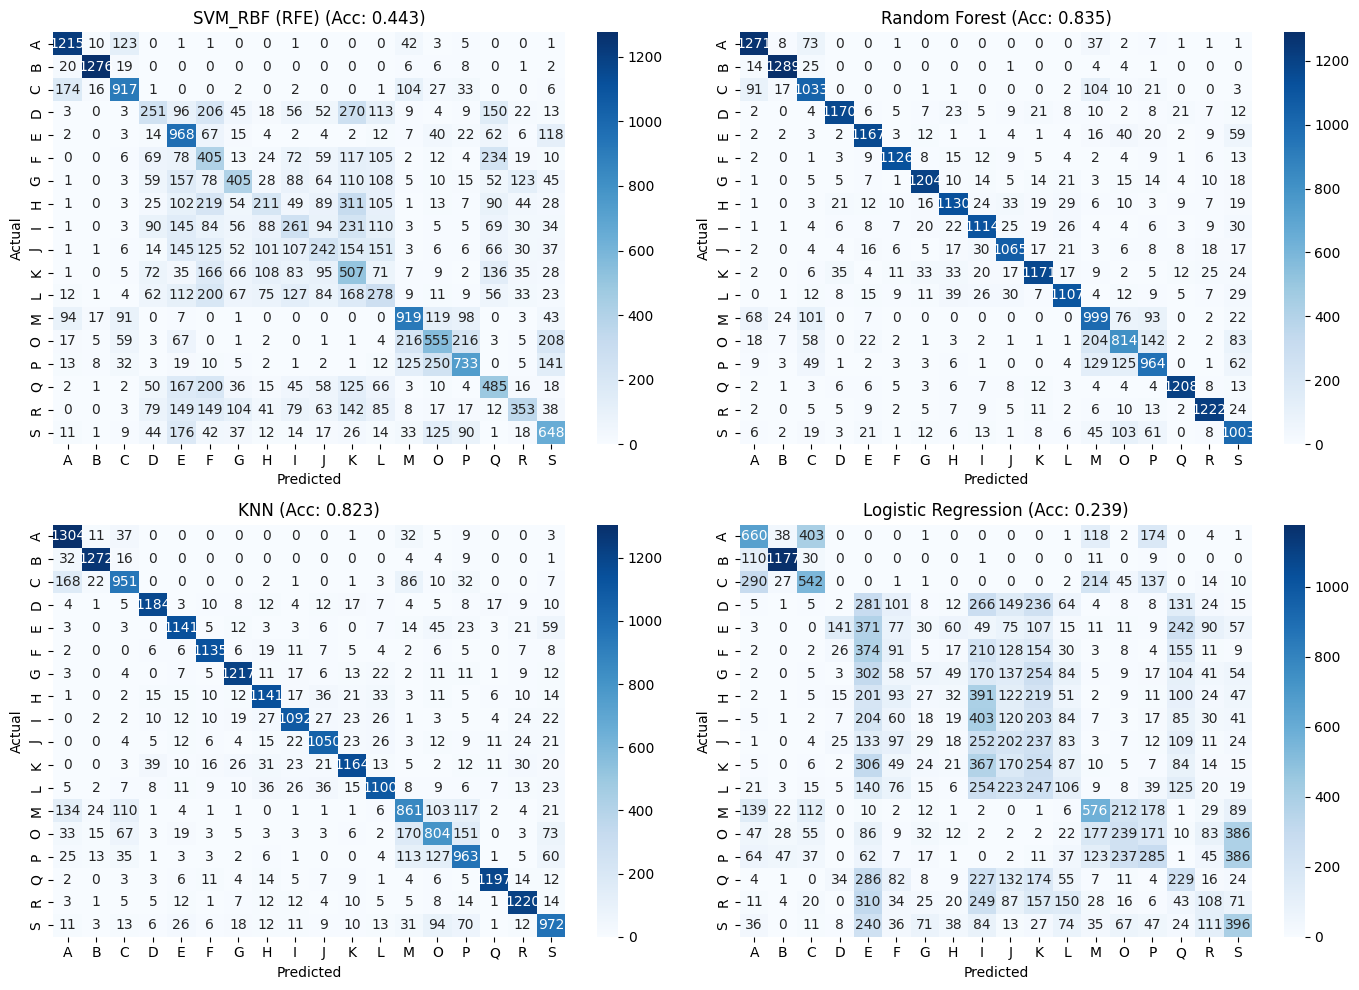

In [23]:
# --- Results and Plots ---
print('--- Final Results ---')
results = pd.DataFrame({
    'Model': ['SVM_RBF (RFE)', 'Random Forest', 'KNN', 'Logistic Regression'],
    'Accuracy': [svm_acc, rf_acc, knn_acc, lr_acc]
})
print('\n=== ACCURACY COMPARISON ===')
print(results.sort_values(by='Accuracy', ascending=False))

# Identify best model based on accuracy
best_model_name = results.loc[results['Accuracy'].idxmax(), 'Model']
print('\n BEST MODEL:', best_model_name)

# Confusion Matrices Plot
models = {
    'SVM_RBF (RFE)': y_pred_svm,
    'Random Forest': y_pred_rf,
    'KNN': y_pred_knn,
    'Logistic Regression': y_pred_lr
}

plt.figure(figsize=(14,10))
plot_idx = 1
for i, (name, preds) in enumerate(models.items()):
    if len(preds) == 0: # Skip plotting if model failed
        print(f'Skipping plot for {name} as it failed to run.')
        continue
    cm = confusion_matrix(y_test, preds)
    plt.subplot(2, 2, plot_idx)
    plot_idx += 1
    # Get unique labels sorted
    labels = np.unique(y_test)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f'{name} (Acc: {results.iloc[i, 1]:.3f})')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
plt.tight_layout()
plt.show()